In [32]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import tensorflow as tf

# Preprocess the LandCover Data

In [3]:
def read_label(label_raster_path):
    with rasterio.open(label_raster_path) as label:
        label_arr=label.read(1)
    return label_arr
label_arr=read_label('Rasters/cdl_new.tif')
def read_raster_data(raster_data_path):
    with rasterio.open(raster_data_path) as rast_data:
        rast_data_arr=rast_data.read()
        rast_data_arr=rast_data_arr.reshape((rast_data_arr.shape[1],rast_data_arr.shape[2],rast_data_arr.shape[0]))
    return rast_data_arr
rast_data=read_raster_data('Rasters/new1.tif')

In [4]:
#Finding corner points 
def find_corners(cdl_arr):
    corners=[(0,0)] # the left top corner the begining of the image.
    fixed=corners[-1][0]
    for i in range(cdl_arr.shape[1]):
        if cdl_arr[fixed][i]==0:
            corners.append((fixed,i-1)) # right top
            break
    fixed=corners[-1][1]
    for i in range(cdl_arr.shape[0]):
        if cdl_arr[i][fixed]==0:
            corners.append((i-1,fixed)) #right bottom
            corners.append((i-1,0)) #left bottom
            break
    return corners

find_corners(label_arr)
rast_data.shape,label_arr.shape


((4373, 4021, 5), (4373, 4021))

In [5]:
def wh_max(label_arr,patch_size):
    corners=find_corners(label_arr)
    xy_min=min(min(rast_data.shape[:2]),min(label_arr.shape)) # the right top y coordinate or the right bottom x coordinate
    width= int(xy_min/patch_size)*patch_size
    return width
max_width=wh_max(label_arr,64)
(max_width/64*max_width/64)/2

1922.0

In [6]:
def train_test_quaters(label_arr,patch_size):
    max_width=wh_max(label_arr,patch_size)
    max_height=max_width
    train_quater=[(int(max_width/2)+1,0),(max_height-patch_size,max_width-patch_size)]
    validate_quater=[(0,0),(int(max_height/2),int(max_width/2))]
    test_quater=[(0,int(max_width/2+1)),(int(max_height/2),max_width-patch_size)]
    return [train_quater,validate_quater,test_quater]
train_test_quaters(label_arr,64)

[[(1985, 0), (3904, 3904)], [(0, 0), (1984, 1984)], [(0, 1985), (1984, 3904)]]

{1: 4308011, 5: 7576650, 6: 26478, 23: 1575780, 28: 324, 36: 4140, 37: 44142, 41: 1206504, 42: 14496, 61: 864, 111: 12912, 121: 685973, 122: 66384, 123: 25704, 124: 3168, 131: 936, 141: 143922, 142: 396, 152: 36, 176: 201858, 190: 37866, 195: 276128}
re_mapping {0: 1, 1: 5, 2: 6, 3: 23, 4: 28, 5: 36, 6: 37, 7: 41, 8: 42, 9: 61, 10: 111, 11: 121, 12: 122, 13: 123, 14: 124, 15: 131, 16: 141, 17: 142, 18: 152, 19: 176, 20: 190, 21: 195}
mapping {1: 0, 5: 1, 6: 2, 23: 3, 28: 4, 36: 5, 37: 6, 41: 7, 42: 8, 61: 9, 111: 10, 121: 11, 122: 12, 123: 13, 124: 14, 131: 15, 141: 16, 142: 17, 152: 18, 176: 19, 190: 20, 195: 21}


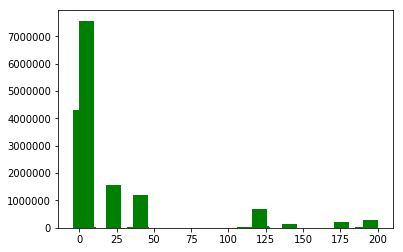

In [7]:
def label_encode_dict(label_arr):
    classes,counts=np.unique(label_arr,return_counts=True)
    class_count=dict(zip(classes,counts))
    print( class_count)
    plt.bar( class_count.keys(),class_count.values(), width=1.0, color='g')
    plt.show
    one_hot_dict={value:key for key, value in enumerate(classes)}
    return one_hot_dict, class_count
mapping,class_count=label_encode_dict(label_arr[:3968+64,:3968+64])
plt.bar( class_count.keys(),class_count.values(), width=10.0, color='g')
re_mapping={value:key for key,value in mapping.items()}
print("re_mapping",re_mapping)
print("mapping",mapping)

In [8]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced'
                                               ,np.unique(label_arr[:3968+64,:3968+64])
                                               ,label_arr[:3968+64,:3968+64].ravel())

<BarContainer object of 22 artists>

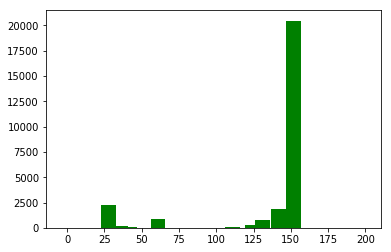

In [9]:
plt.bar( class_count.keys(),class_weight, width=10.0, color='g')

In [10]:
len(np.unique(label_arr[:3968+64,:3968+64]))

22

In [11]:
def read_labels_patch(label_arr,x_cord,y_cord,patch_size):
    label_encode=np.zeros((patch_size,patch_size,len(mapping.keys())))
    for i in range(patch_size):
        for j in range(patch_size):
            label_encode[i][j][mapping[label_arr[x_cord+i][y_cord+j]]]=1
    return label_encode
temp=read_labels_patch(label_arr,0,0,64)
temp.shape

(64, 64, 22)

In [12]:
def read_data_patch(rast_data,x_cord,y_cord,patch_size):
    #data_patch=np.zeros((patch_size,patch_size,rast_data.shape[2]))
    data_patch=rast_data[x_cord:x_cord+patch_size,y_cord:y_cord+patch_size]
#     for i in range(patch_size):
#         for j in range(patch_size):
#             data_patch[i][j]=rast_data[x_cord+i][y_cord+j]
    return data_patch
read_data_patch(rast_data,0,0,64).shape


(64, 64, 5)

In [13]:
#Parameters
patch_size=64
num_classes=22
batch_size=64
num_channels=5
train_steps=1922
val_steps=1000
test_steps=1000
num_epochs=100
quarters=train_test_quaters(label_arr,patch_size)

# Normalizing

In [14]:
from xml.dom import minidom
def normalize_xml(rast_data,xml_file):
    xml_doc=minidom.parse(xml_file)
    nodes=xml_doc.getElementsByTagName("re:bandSpecificMetadata")
    coeffs = {}
    for node in nodes:
        bn = node.getElementsByTagName("re:bandNumber")[0].firstChild.data
        if bn in ['1', '2', '3', '4']:
            i = int(bn)
            value = node.getElementsByTagName("re:radiometricScaleFactor")[0].firstChild.data
            coeffs[i] = float(value)
    #rast_data=[rast_data[i]*coeffs[i+1] for i in range(4)]
    for i in range(4):
        rast_data[i]=rast_data[i]*coeffs[i+1]
        
        #norm_bands.append(band)
    return rast_data
xml_file='1460322_2014-08-13_RE2_3A_305154_metadata.xml'
norm_bands=normalize_xml(rast_data,xml_file)
norm_bands[:,:,0].shape

(4373, 4021)

# Adding a layer of Regression b/n red and nir using the sliding window

In [15]:
def read_pixel_array(b1_in,b2_in):
    
    width,height=b1_in.shape
    
    b11_in=b1_in * b1_in
    b22_in=b2_in*b2_in
    b12_in=b1_in*b2_in
    '''
     #flatten the arrarys 
    b1_in_flat=b1_in.flatten()
    b2_in_flat=b2_in.flatten()
    b11_in_flat=b11_in.flatten()
    b22_in_flat=b22_in.flatten()
    b12_in_flat=b12_in.flatten()
    '''
    b_in_list =list((b1_in,b2_in, b11_in,b22_in,b12_in)) 
    return b_in_list,width,height

In [16]:
def sliding_window(band_in_list,width,height,w_size,method):
    
    delta=w_size//2
    col_extent_old = width - delta + 1
    row_extent = width - delta + 1
    col_extent = height - delta + 1
    
    #select the block indecies
    selector = lambda a: np.lib.stride_tricks.as_strided(a, shape=(row_extent,col_extent,delta,delta), strides=a.strides+a.strides)
    # Get offsetted indices across the height and width of input array
    #output_index_set = np.arange(row_extent)[:,None]*col_extent_old + np.arange(col_extent)
    #full_selector = np.lib.stride_tricks.as_strided(band_in_list[0], shape=(row_extent,col_extent,delta,delta), strides=band_in_list[0].strides+band_in_list[0].strides)
    
    #implement the selector on the arrays
    '''
    b1_in_selc=np.take(band_in_list[0],selector(band_in_list[0]).astype(float))
    b2_in_selc=np.take(band_in_list[1],selector(band_in_list[1]).astype(float))
    b11_in_selc=np.take(band_in_list[2],selector(band_in_list[2]).astype(float))
    b22_in_selc=np.take(band_in_list[3],selector(band_in_list[3]).astype(float))
    b12_in_selc=np.take(band_in_list[4],selector(band_in_list[4]).astype(float))
    '''
    band_out_list=[]
    if method=='sum':
        for band in band_in_list:
            band_out_list.append(np.sum(selector(band),axis=(2,3)))
    elif method=='mean':
        for band in band_in_list:
            band_out_list.append(np.mean(selector(band),axis=(2,3)))
    elif method=='max':
        for band in band_in_list:
            band_out_list.append(np.max(selector(band),axis=(2,3)))
    elif method=='min':
        for band in band_in_list:
            band_out_list.append(np.min(selector(band),axis=(2,3)))
    return band_out_list

In [17]:
def windowRegression(band_out_list,w):
    #x_diff = x_max-w+1
    #y_diff = y_max-w+1
    size = band_out_list[0].size
    count = w*w
    m = np.empty(size)
    
    if any(band.size!=size for band in band_out_list):
        print(size)
        #print(band.size)
        raise ValueError('In windowRegression: x_max and/or y_max inconsistent with length of a, b, aa, and / or ab')

    numerator = count * band_out_list[-1] - band_out_list[0]* band_out_list[1]
    denominator = count * band_out_list[2] - band_out_list[0] * band_out_list[0]
    m = numerator/denominator
    return m

In [18]:
w_size=8
red_band,nir_band=norm_bands[:,:,2],norm_bands[:,:,3]
print(red_band.shape)
bands_in,w,h=read_pixel_array(red_band,nir_band)
bands_out=sliding_window(bands_in,w,h,w_size,'sum')
reg_band=windowRegression(bands_out,w_size)
reg_band.shape


(4373, 4021)


(4370, 4018)

In [19]:
norm_bands[:-3,:-3,:].shape

(4370, 4018, 5)

In [20]:
rast_data=np.dstack((norm_bands[:-3,:-3,:],reg_band))
rast_data.shape

(4370, 4018, 6)

In [21]:
# 0 for train 1 for val and 2 for test
def data_read(rast_data,label_data,patch_size,batch_size,mode=0):
    quater=quarters[mode]
    while True:
        data,label=[],[]
        for i in range(batch_size):
            x_cord=np.random.randint(quater[0][0],quater[1][0])
            y_cord=np.random.randint(quater[0][1],quater[1][1])
            data.append(read_data_patch(rast_data,x_cord,y_cord,patch_size))
            label.append(read_labels_patch(label_arr,x_cord,y_cord,patch_size))
        data=np.array(data)
        label=np.array(label)
        yield data,label

#train_data,train_label=train_data.reshape(-1,num_channels),train_label.reshape(-1,num_classes)
#print(train_data.shape,train_label.shape)

In [22]:
generator_train=data_read(norm_bands,label_arr,patch_size,batch_size,0)
for train_data,train_label in generator_train:
    print(train_data.shape,train_label.shape)
    break

(64, 64, 64, 5) (64, 64, 64, 22)


In [23]:
generator_val=data_read(norm_bands,label_arr,patch_size,batch_size,1)
for test_data,test_label in generator_val:
    print(test_data.shape,test_label.shape)
    break

(64, 64, 64, 5) (64, 64, 64, 22)


In [24]:
generator_test=data_read(norm_bands,label_arr,patch_size,batch_size,2)
for test_data,test_label in generator_test:
    print(test_data.shape,test_label.shape)
    break

(64, 64, 64, 5) (64, 64, 64, 22)


In [25]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,LearningRateScheduler


In [26]:
from tensorflow.keras import backend as K
def f_measure(y_true, y_pred):
    """
    f_measure: Harmonic mean of specificity and sensitivity, shall be used to calculate score batch wise
    during training
    **for binary classification only**
    @param
    y_true: Tensor of actual labels 
    y_pred: Tensor of predicted labels 
    @returns 
    f_measure score for a batch 
    """
    def specificity(y_true, y_pred):
        """Compute the confusion matrix for a set of predictions.
    
        Parameters
        ----------
        y_pred   : predicted values for a batch if samples (must be binary: 0 or 1)
        y_true   : correct values for the set of samples used (must be binary: 0 or 1)
    
        Returns
        -------
        out : the specificity
        """
        neg_y_true = 1 - y_true
        neg_y_pred = 1 - y_pred
        fp = K.sum(neg_y_true * y_pred)
        tn = K.sum(neg_y_true * neg_y_pred)
        
        specificity = tn / (tn + fp + K.epsilon())
        return specificity
    
    def recall(y_true, y_pred):
        """Recall metric.
        
        Only computes a batch-wise average of recall.
        
        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall
    
    specificity = specificity(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((specificity * recall)/(specificity + recall + K.epsilon()))




def f1_score(y_true, y_pred):
    """Computes the F score.
     The F1 score is harmonic mean of precision and recall.
     it is computed as a batch-wise average.
     This is can be used for multi-label classification. 
    """
    
    
    def precision(y_true, y_pred):
        """Precision metric.
         Only computes a batch-wise average of precision.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    def recall(y_true, y_pred):
        """Recall metric.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    f1_score = 2 * (p * r) / (p + r + K.epsilon())
    return f1_score

In [27]:
from tensorflow.keras.utils import multi_gpu_model

In [34]:
model = Sequential()
model.add(BatchNormalization(input_shape=(patch_size,patch_size,num_channels)))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Conv2D(num_classes, (3, 3), padding='same'))
model.add(Activation('softmax'))

# initiate Adam optimizer
opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)

parallel_model = multi_gpu_model(model,gpus=2, cpu_merge=False)
# Let's train the model using Adam
parallel_model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy',f_measure])
parallel_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
batch_normalization_3_input (In (None, 64, 64, 5)    0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 64, 64, 5)    0           batch_normalization_3_input[0][0]
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 64, 64, 5)    0           batch_normalization_3_input[0][0]
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 64, 64, 22)   79242       lambda_2[0][0]                   
                                                                 lambda_3[0][0]                   
__________

In [35]:
callbacks = [EarlyStopping(monitor='val_loss', patience=5),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

In [36]:
parallel_model.fit_generator(generator_train,steps_per_epoch=train_steps,
                   epochs=num_epochs, callbacks=callbacks, validation_data=generator_val,
                    validation_steps=val_steps,class_weight=class_weight,
                    max_queue_size=10, workers=8,
                    use_multiprocessing=True, shuffle=True)

Epoch 1/100
1922/1922 [==============================] - 586s 305ms/step - loss: 95.1801 - acc: 0.4574 - f_measure: 0.1804 - val_loss: 100.6784 - val_acc: 0.4680 - val_f_measure: 0.0781
Epoch 2/100
1922/1922 [==============================] - 596s 310ms/step - loss: 93.7590 - acc: 0.4611 - f_measure: 0.1494 - val_loss: 103.1402 - val_acc: 0.4302 - val_f_measure: 0.0667
Epoch 3/100
1922/1922 [==============================] - 587s 305ms/step - loss: 93.7333 - acc: 0.4604 - f_measure: 0.1401 - val_loss: 100.2618 - val_acc: 0.4669 - val_f_measure: 0.0387
Epoch 4/100
1922/1922 [==============================] - 595s 309ms/step - loss: 93.3053 - acc: 0.4628 - f_measure: 0.1553 - val_loss: 101.5284 - val_acc: 0.4397 - val_f_measure: 0.0385
Epoch 5/100
1922/1922 [==============================] - 589s 306ms/step - loss: 93.2235 - acc: 0.4610 - f_measure: 0.1439 - val_loss: 101.7455 - val_acc: 0.4718 - val_f_measure: 0.1212
Epoch 6/100
1922/1922 [==============================] - 586s 305ms/st

In [37]:
parallel_model.evaluate_generator(generator_test,steps=test_steps,verbose=1)

1000/1000 [==============================] - 187s 187ms/step


[106.64414714813232, 0.48072733306884763, 0.1248791414834559]

In [ ]:
from PIL import Image
predicted=np.zeros((max_width,max_width))
#for i in range(0,max_width,patch_size):
predict=parallel_model.predict_generator(generator_test,steps=test_steps,verbose=1)
for key in remapping: 
    predict[predict==key]=remapping[key]
    
img=Image.fromarray(predict)
img.save('predicted.png')
img.show()

 937/1000 [===========================>..] - ETA: 29s

# UNET

In [28]:
def unet(pretrained_weights = None,input_shape=(patch_size,patch_size,num_channels)):
    inputs = Input(input_shape)
    #inputs = BatchNormalization()(inputs)
    conv1 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512,(2,2), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, (2,2), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, (2,2), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, (2,2), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(num_classes, (3, 3), activation = 'softmax',padding = 'same')(conv9)

    model = Model(inputs, conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'categorical_crossentropy', metrics=['accuracy',f_measure])
    
    print(model.summary())

    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

In [29]:
callbacks = [EarlyStopping(monitor='val_loss', patience=5),
             ModelCheckpoint(filepath='unet_membrane.hdf5', monitor='val_loss', save_best_only=True)]

In [30]:
model=unet()

model.fit_generator(generator_train,steps_per_epoch=train_steps,
                   epochs=num_epochs, callbacks=callbacks, validation_data=generator_val,
                    validation_steps=val_steps,class_weight=class_weight,
                    max_queue_size=10, workers=8,
                    use_multiprocessing=True, shuffle=True)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 5)    0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 64)   2944        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 64)   36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 32, 32, 64)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (

In [31]:
model.evaluate_generator(generator_test,steps=test_steps,verbose=1)

1000/1000 [==============================] - 204s 204ms/step


[103.32558403015136, 0.48488019180297853, 0.0]





# UNET for Sat Image

In [51]:
def unet_sat(n_classes=num_classes, im_sz=patch_size, n_channels=num_channels, n_filters_start=32, growth_factor=2, upconv=True,
               class_weights=class_weight):
    droprate=0.25
    n_filters = n_filters_start
    inputs = Input((im_sz, im_sz, n_channels))
    inputs = BatchNormalization()(inputs)
    conv1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    #pool1 = Dropout(droprate)(pool1)

    n_filters *= growth_factor
    pool1 = BatchNormalization()(pool1)
    conv2 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = Dropout(droprate)(pool2)

    n_filters *= growth_factor
    pool2 = BatchNormalization()(pool2)
    conv3 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3 = Dropout(droprate)(pool3)

    n_filters *= growth_factor
    pool3 = BatchNormalization()(pool3)
    conv4_0 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(pool3)
    conv4_0 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv4_0)
    pool4_1 = MaxPooling2D(pool_size=(2, 2))(conv4_0)
    pool4_1 = Dropout(droprate)(pool4_1)

    n_filters *= growth_factor
    pool4_1 = BatchNormalization()(pool4_1)
    conv4_1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(pool4_1)
    conv4_1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv4_1)
    pool4_2 = MaxPooling2D(pool_size=(2, 2))(conv4_1)
    pool4_2 = Dropout(droprate)(pool4_2)

    n_filters *= growth_factor
    conv5 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(pool4_2)
    conv5 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv5)

    n_filters //= growth_factor
    if upconv:
        up6_1 = concatenate([Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv5), conv4_1])
    else:
        up6_1 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4_1])
    up6_1 = BatchNormalization()(up6_1)
    conv6_1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(up6_1)
    conv6_1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv6_1)
    conv6_1 = Dropout(droprate)(conv6_1)

    n_filters //= growth_factor
    if upconv:
        up6_2 = concatenate([Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv6_1), conv4_0])
    else:
        up6_2 = concatenate([UpSampling2D(size=(2, 2))(conv6_1), conv4_0])
    up6_2 = BatchNormalization()(up6_2)
    conv6_2 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(up6_2)
    conv6_2 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv6_2)
    conv6_2 = Dropout(droprate)(conv6_2)

    n_filters //= growth_factor
    if upconv:
        up7 = concatenate([Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv6_2), conv3])
    else:
        up7 = concatenate([UpSampling2D(size=(2, 2))(conv6_2), conv3])
    up7 = BatchNormalization()(up7)
    conv7 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = Dropout(droprate)(conv7)

    n_filters //= growth_factor
    if upconv:
        up8 = concatenate([Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv7), conv2])
    else:
        up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2])
    up8 = BatchNormalization()(up8)
    conv8 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = Dropout(droprate)(conv8)

    n_filters //= growth_factor
    if upconv:
        up9 = concatenate([Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv8), conv1])
    else:
        up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1])
    conv9 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(n_classes, (1, 1), activation='softmax')(conv9)

    model = Model(inputs, conv10)
    print(model.summary())

    def weighted_binary_crossentropy(y_true, y_pred):
        class_loglosses = K.mean(K.binary_crossentropy(y_true, y_pred), axis=[0, 1, 2])
        return K.sum(class_loglosses * K.constant(class_weights))
    
    parallel_model = multi_gpu_model(model,gpus=2, cpu_merge=False)
    parallel_model.compile(optimizer=Adam(), loss='categorical_crossentropy',metrics=['accuracy',f_measure])
    return parallel_model

In [52]:
callbacks = [EarlyStopping(monitor='val_loss', patience=5),
             ModelCheckpoint(filepath='unet_membrane.hdf5', monitor='val_loss', save_best_only=True)]

In [53]:
model=unet_sat()

model.fit_generator(generator_train,steps_per_epoch=train_steps,
                   epochs=num_epochs, callbacks=callbacks, validation_data=generator_val,
                    validation_steps=val_steps,class_weight=class_weight,
                    max_queue_size=10, workers=8,
                    use_multiprocessing=True, shuffle=True)

AttributeError: 'Model' object has no attribute '_name'

In [106]:
model.evaluate_generator(generator_test,steps=test_steps,verbose=1)

1000/1000 [==============================] - 94s 94ms/step


[322.99516000366214, 0.48488114166259766, 0.6360743516087533]

# Tensorflow CNN Model

In [13]:
def create_placeholder(batch_size,width,height,n_channel,n_class):
    X=tf.placeholder(tf.float32,shape=(None,width*height,n_channel))
    y=tf.placeholder(tf.float32,shape=(None,n_class))
    return X,Y

In [31]:
def intialize_parameters():
    tf.set_random_seed(1)
    W1=tf.get_variable("W1",[1,4,5,8],initializer=tf.contrib.layers.xavier_initializer(seed=0))
    W2=tf.get_variable("W2",[1,2,8,16],initializer=tf.contrib.layers.xavier_initializer(seed=0))
    parameters={"W1":W1,
                "W2":W2}
    return parameters
    

In [32]:
def forward_propagation(X,parameters):
    W1=parameters['W1']
    W2=parameters['W2']
    Z1=tf.nn.conv2d(X,W1,strides=[1,1,1,1],padding='SAME')
    A1=tf.nn.relu(Z1)
    P1=tf.nn.max_pool(A1,ksize=[1,8,8,1],padding='SAME')
    Z2=tf.nn.conv2d(P1,W2,strides=[1,1,1,1],padding='SAME')
    A2=tf.nn.relu(Z2)
    P2=tf.nnmax_pool(A2,ksize=[1,4,4,1],padding='SAME')
    P2=tf.contrib.layers.flatten(P2)
    Z3=tf.contrib.layers.fully_connected(P2,num_outputs=23,activation_fn=None)
    return Z3

In [ ]:
tf.reset_default_graph()
with tf.Session() as sess:
    np.random.seed(1)
    X,Y=create_placeholder(32,32,5,24)
    parameters=initialize_parameters()
    Z3=forward_propagation(X,parameters)